In [1]:
import pandas as pd
import numpy as np
import keras_contrib
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
import csv
import os
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(10)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence

Using TensorFlow backend.


In [2]:
tsvfile=open("BC5CDR-IOB/train.tsv",encoding="utf-8")
tsvreader = csv.reader(tsvfile, delimiter="\t")
data=[]
sentences=[]
words=[]
tags=[]
maxsentlen=0
for line in tsvreader:
    if line!=[]:
        data.append(line)
        if line[0] not in words:
            words.append(line[0])
        if line[1] not in tags:
            tags.append(line[1])
    else:
        sentences.append(data)
        if maxsentlen<len(data):
            maxsentlen=len(data)
        data=[]

In [3]:
print(len(sentences))
print(len(words))

4560
9980


In [4]:
word_to_index = {w : i + 2 for i, w in enumerate(words)}
print(word_to_index[words[0]])
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
print(tag_to_index[tags[0]])

tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
print(idx2word[2])
idx2tag = {i: w for w, i in tag_to_index.items()}
print(len(tag_to_index))

2
1
Selegiline
6


In [34]:
# Number of data points passed in each iteration
batch_size =50
# Passes through entire dataset
epochs = 50
# Maximum length of review
max_len = maxsentlen+15
# Dimension of embedding vector
embedding = 200

In [35]:
X = [[word_to_index[w[0]] for w in s] for s in sentences]
print(X[0],X[1])
count=0
for s in sentences:
    print(s)
    count=count+1
    if count>5:
        break
# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] [23, 12, 24, 25, 26, 8, 9, 10, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 7, 38, 39, 8, 9, 10, 11, 30, 40, 32, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 3, 51, 52, 39, 53, 54, 50, 3, 51, 55, 22]
[['Selegiline', 'B-Chemical'], ['-', 'O'], ['induced', 'O'], ['postural', 'B-Disease'], ['hypotension', 'I-Disease'], ['in', 'O'], ['Parkinson', 'B-Disease'], ["'", 'I-Disease'], ['s', 'I-Disease'], ['disease', 'I-Disease'], [':', 'O'], ['a', 'O'], ['longitudinal', 'O'], ['study', 'O'], ['on', 'O'], ['the', 'O'], ['effects', 'O'], ['of', 'O'], ['drug', 'O'], ['withdrawal', 'O'], ['.', 'O']]
[['OBJECTIVES', 'O'], [':', 'O'], ['The', 'O'], ['United', 'O'], ['Kingdom', 'O'], ['Parkinson', 'B-Disease'], ["'", 'I-Disease'], ['s', 'I-Disease'], ['Disease', 'I-Disease'], ['Research', 'O'], ['Group', 'O'], ['(', 'O'], ['UKPDRG', 'O'], [')', 'O'], ['trial', 'O'], ['found', 'O'], ['an', 'O'], ['increased', 'O'], ['mortality', 'O'

In [36]:
print(X[0])
len(X[0])

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


169

In [37]:
# Convert label to index
y = [[tag_to_index[w[1]] for w in s] for s in sentences]
print(y[0])
# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

[1, 2, 2, 3, 4, 2, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [38]:
num_tag = 5
print(num_tag)
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]
print(y[0][1],y[0][18])
print(len(y[0][1]))

5
[0. 0. 1. 0. 0. 0.] [0. 0. 1. 0. 0. 0.]
6


In [41]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])
len(X[0])

*****Before Processing first sentence : *****
 Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal .
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


169

In [42]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[1] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 B-Chemical O O B-Disease I-Disease O B-Disease I-Disease I-Disease I-Disease O O O O O O O O O O O
*****After Processing first sentence : *****
  [[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [ ]:
num_tags = 5
# Model architecture
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
model = Bidirectional(LSTM(units = 100, return_sequences=True, recurrent_dropout=0.1))(model)
crf = CRF(num_tags+1)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

In [44]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [45]:
history = model.fit(X, np.array(y), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1,callbacks=callbacks_list)

Train on 4104 samples, validate on 456 samples
Epoch 1/10
4104/4104 [==============================] - ETA: 4:28 - loss: 15.1731 - crf_viterbi_accuracy: 0.022 - ETA: 2:48 - loss: 15.7501 - crf_viterbi_accuracy: 0.022 - ETA: 2:15 - loss: 16.0301 - crf_viterbi_accuracy: 0.020 - ETA: 1:58 - loss: 15.9194 - crf_viterbi_accuracy: 0.020 - ETA: 1:48 - loss: 16.0189 - crf_viterbi_accuracy: 0.123 - ETA: 1:40 - loss: 15.8766 - crf_viterbi_accuracy: 0.244 - ETA: 1:35 - loss: 16.0469 - crf_viterbi_accuracy: 0.334 - ETA: 1:30 - loss: 15.9434 - crf_viterbi_accuracy: 0.403 - ETA: 1:27 - loss: 15.7416 - crf_viterbi_accuracy: 0.455 - ETA: 1:24 - loss: 15.4563 - crf_viterbi_accuracy: 0.496 - ETA: 1:22 - loss: 15.1216 - crf_viterbi_accuracy: 0.532 - ETA: 1:19 - loss: 15.1222 - crf_viterbi_accuracy: 0.561 - ETA: 1:17 - loss: 14.9999 - crf_viterbi_accuracy: 0.585 - ETA: 1:15 - loss: 14.9596 - crf_viterbi_accuracy: 0.606 - ETA: 1:13 - loss: 14.9751 - crf_viterbi_accuracy: 0.625 - ETA: 1:11 - loss: 14.9107 -

4104/4104 [==============================] - ETA: 1:30 - loss: 12.3355 - crf_viterbi_accuracy: 0.924 - ETA: 1:34 - loss: 14.0380 - crf_viterbi_accuracy: 0.943 - ETA: 1:36 - loss: 14.0747 - crf_viterbi_accuracy: 0.949 - ETA: 1:35 - loss: 14.6791 - crf_viterbi_accuracy: 0.949 - ETA: 1:34 - loss: 14.2143 - crf_viterbi_accuracy: 0.949 - ETA: 1:32 - loss: 14.2908 - crf_viterbi_accuracy: 0.952 - ETA: 1:30 - loss: 14.2176 - crf_viterbi_accuracy: 0.953 - ETA: 1:30 - loss: 14.5100 - crf_viterbi_accuracy: 0.955 - ETA: 1:28 - loss: 14.2941 - crf_viterbi_accuracy: 0.952 - ETA: 1:27 - loss: 14.0443 - crf_viterbi_accuracy: 0.951 - ETA: 1:26 - loss: 13.9539 - crf_viterbi_accuracy: 0.949 - ETA: 1:25 - loss: 13.8124 - crf_viterbi_accuracy: 0.951 - ETA: 1:23 - loss: 13.8790 - crf_viterbi_accuracy: 0.951 - ETA: 1:22 - loss: 14.1002 - crf_viterbi_accuracy: 0.952 - ETA: 1:21 - loss: 14.1147 - crf_viterbi_accuracy: 0.953 - ETA: 1:19 - loss: 14.0291 - crf_viterbi_accuracy: 0.953 - ETA: 1:18 - loss: 13.9538 -

4104/4104 [==============================] - ETA: 1:26 - loss: 12.8063 - crf_viterbi_accuracy: 0.963 - ETA: 1:27 - loss: 12.1112 - crf_viterbi_accuracy: 0.974 - ETA: 1:29 - loss: 12.6002 - crf_viterbi_accuracy: 0.977 - ETA: 1:29 - loss: 12.5172 - crf_viterbi_accuracy: 0.977 - ETA: 1:29 - loss: 12.5195 - crf_viterbi_accuracy: 0.978 - ETA: 1:28 - loss: 12.9297 - crf_viterbi_accuracy: 0.978 - ETA: 1:27 - loss: 13.3480 - crf_viterbi_accuracy: 0.977 - ETA: 1:25 - loss: 13.4474 - crf_viterbi_accuracy: 0.977 - ETA: 1:25 - loss: 13.5313 - crf_viterbi_accuracy: 0.977 - ETA: 1:24 - loss: 13.7685 - crf_viterbi_accuracy: 0.977 - ETA: 1:23 - loss: 13.8423 - crf_viterbi_accuracy: 0.976 - ETA: 1:21 - loss: 13.8044 - crf_viterbi_accuracy: 0.976 - ETA: 1:20 - loss: 13.6901 - crf_viterbi_accuracy: 0.977 - ETA: 1:20 - loss: 13.6553 - crf_viterbi_accuracy: 0.978 - ETA: 1:19 - loss: 13.7633 - crf_viterbi_accuracy: 0.978 - ETA: 1:18 - loss: 13.6714 - crf_viterbi_accuracy: 0.978 - ETA: 1:17 - loss: 13.6848 -

4104/4104 [==============================] - ETA: 1:22 - loss: 16.1908 - crf_viterbi_accuracy: 0.986 - ETA: 1:27 - loss: 14.6939 - crf_viterbi_accuracy: 0.978 - ETA: 1:28 - loss: 14.0201 - crf_viterbi_accuracy: 0.980 - ETA: 1:27 - loss: 14.4535 - crf_viterbi_accuracy: 0.983 - ETA: 1:27 - loss: 15.4380 - crf_viterbi_accuracy: 0.982 - ETA: 1:26 - loss: 15.1721 - crf_viterbi_accuracy: 0.982 - ETA: 1:25 - loss: 14.8414 - crf_viterbi_accuracy: 0.983 - ETA: 1:24 - loss: 14.8808 - crf_viterbi_accuracy: 0.984 - ETA: 1:23 - loss: 14.6065 - crf_viterbi_accuracy: 0.985 - ETA: 1:22 - loss: 14.4934 - crf_viterbi_accuracy: 0.986 - ETA: 1:21 - loss: 14.3760 - crf_viterbi_accuracy: 0.986 - ETA: 1:20 - loss: 14.1778 - crf_viterbi_accuracy: 0.985 - ETA: 1:19 - loss: 14.2518 - crf_viterbi_accuracy: 0.986 - ETA: 1:18 - loss: 14.1521 - crf_viterbi_accuracy: 0.986 - ETA: 1:16 - loss: 14.0647 - crf_viterbi_accuracy: 0.986 - ETA: 1:15 - loss: 14.2019 - crf_viterbi_accuracy: 0.986 - ETA: 1:14 - loss: 14.3487 -

4104/4104 [==============================] - ETA: 1:34 - loss: 13.6621 - crf_viterbi_accuracy: 0.966 - ETA: 1:31 - loss: 13.4790 - crf_viterbi_accuracy: 0.980 - ETA: 1:30 - loss: 14.2701 - crf_viterbi_accuracy: 0.985 - ETA: 1:28 - loss: 14.2826 - crf_viterbi_accuracy: 0.986 - ETA: 1:26 - loss: 14.8170 - crf_viterbi_accuracy: 0.987 - ETA: 1:25 - loss: 15.3980 - crf_viterbi_accuracy: 0.987 - ETA: 1:24 - loss: 14.8383 - crf_viterbi_accuracy: 0.988 - ETA: 1:22 - loss: 15.0876 - crf_viterbi_accuracy: 0.988 - ETA: 1:22 - loss: 15.0291 - crf_viterbi_accuracy: 0.988 - ETA: 1:21 - loss: 14.6635 - crf_viterbi_accuracy: 0.989 - ETA: 1:20 - loss: 14.5971 - crf_viterbi_accuracy: 0.989 - ETA: 1:18 - loss: 14.4133 - crf_viterbi_accuracy: 0.990 - ETA: 1:17 - loss: 14.3480 - crf_viterbi_accuracy: 0.990 - ETA: 1:16 - loss: 14.2046 - crf_viterbi_accuracy: 0.990 - ETA: 1:15 - loss: 14.0827 - crf_viterbi_accuracy: 0.991 - ETA: 1:15 - loss: 14.1382 - crf_viterbi_accuracy: 0.991 - ETA: 1:14 - loss: 14.1914 -

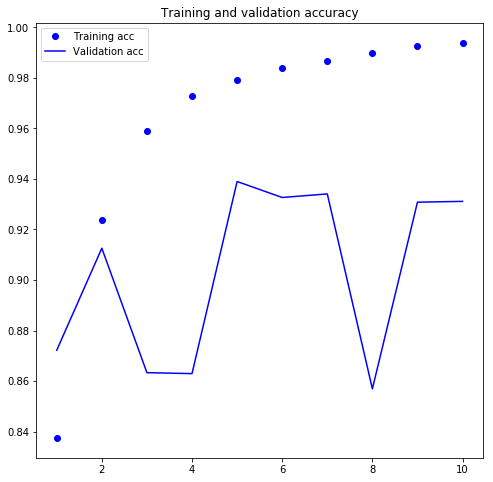

In [47]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

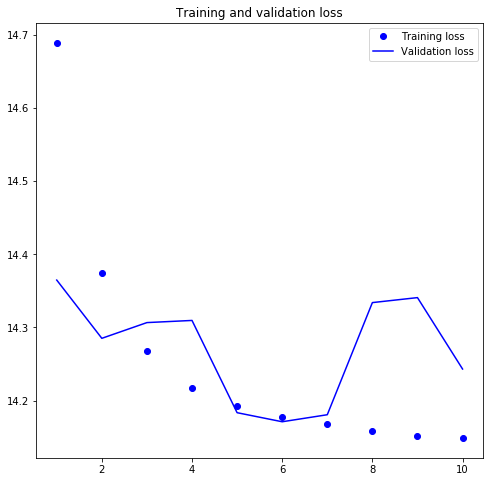

In [48]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [49]:
'''# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)'''

'# Evaluation\ny_pred = model.predict(X_test)\ny_pred = np.argmax(y_pred, axis=-1)\ny_test_true = np.argmax(y_test, -1)'

In [50]:
'''# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] '''

'# Convert the index to tag\ny_pred = [[idx2tag[i] for i in row] for row in y_pred]\ny_test_true = [[idx2tag[i] for i in row] for row in y_test_true] '

In [51]:
'''print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))'''

'print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))'

In [52]:
'''report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)'''

'report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)\nprint(report)'

In [53]:
tsvfile=open("BC5CDR-IOB/test.tsv",encoding="utf-8")
tsvreader = csv.reader(tsvfile, delimiter="\t")
data1=[]
sentences1=[]
words1=[]
tags1=[]
for line in tsvreader:
    if line!=[]:
        data1.append(line)
        if line[0] not in words1:
            words1.append(line[0])
        if line[1] not in tags1:
            tags1.append(line[1])
    else:
        sentences1.append(data1)
        data1=[]

X1 = [[word_to_index[w[0] if w[0] in words else "UNK"] for w in s] for s in sentences1]
print(X1[0],X1[1])
count=0
for s in sentences1:
    print(s)
    count=count+1
    if count>5:
        break
# Padding each sequence to have same length  of each word
X1 = pad_sequences(maxlen = max_len, sequences = X1, padding = "post", value = word_to_index["PAD"])
y1 = [[tag_to_index[w[1]] for w in s] for s in sentences1]
print(y1[0])
# padding
y1 = pad_sequences(maxlen = max_len, sequences = y1, padding = "post", value = tag_to_index["PAD"])
num_tag = 5
print(num_tag)
# One hot encoded labels
y1=[to_categorical(i, num_classes = num_tag + 1) for i in y1]

[1, 2393, 2394, 1163, 524, 304, 978, 268, 1995, 5606, 309, 7, 13, 609, 39, 4022, 2576, 49, 2040, 1140, 78, 22] [24, 1757, 1758, 17, 466, 19, 13, 4565, 3, 637, 3, 785, 1883, 39, 1820, 57, 475, 1140, 78, 1478, 42, 4022, 2576, 49, 991, 19, 184, 1163, 2885, 545, 1627, 2397, 7342, 49, 1, 2393, 2394, 1163, 524, 304, 117, 3535, 19, 1995, 978, 268, 30, 589, 22, 688, 1, 247, 248, 47, 1297, 32, 5606, 22]
[['Torsade', 'B-Disease'], ['de', 'I-Disease'], ['pointes', 'I-Disease'], ['ventricular', 'B-Disease'], ['tachycardia', 'I-Disease'], ['during', 'O'], ['low', 'O'], ['dose', 'O'], ['intermittent', 'O'], ['dobutamine', 'B-Chemical'], ['treatment', 'O'], ['in', 'O'], ['a', 'O'], ['patient', 'O'], ['with', 'O'], ['dilated', 'B-Disease'], ['cardiomyopathy', 'I-Disease'], ['and', 'O'], ['congestive', 'B-Disease'], ['heart', 'I-Disease'], ['failure', 'I-Disease'], ['.', 'O']]
[['The', 'O'], ['authors', 'O'], ['describe', 'O'], ['the', 'O'], ['case', 'O'], ['of', 'O'], ['a', 'O'], ['56', 'O'], ['-', 'O

In [54]:
y_pred = model.predict(X1)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y1, -1)

In [55]:
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [56]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 76.2%


In [57]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

  B-Chemical       0.91      0.61      0.73      5385
   B-Disease       0.61      0.70      0.65      4424
  I-Chemical       0.77      0.54      0.64      1628
   I-Disease       0.49      0.74      0.59      2737
           O       0.97      0.97      0.97    110576
         PAD       1.00      1.00      1.00    685943

    accuracy                           0.99    810693
   macro avg       0.79      0.76      0.76    810693
weighted avg       0.99      0.99      0.99    810693



In [58]:
##Exact Match
TP=0
TN=0
FP=0
FN=0
i=0
nument=0
while i<len(y_test_true):
    j=0
    #print(i)
    while j <len(y_test_true[i]):
        #print('j ',j)
        if y_test_true[i][j]=='B-Disease':
            st=j
            nument=nument+1
            j=j+1
            while (y_test_true[i][j]=='I-Disease') and j<len(y_test_true[i]):
                j=j+1
                #print('inside ',j)
            end=j
            if y_test_true[i][st:end]==y_pred[i][st:end]:
                TP=TP+1
            else:
                FN=FN+1

        elif y_test_true[i][j]=='B-Chemical':
            st=j
            nument=nument+1
            j=j+1
            while (y_test_true[i][j]=='I-Chemical') and j<len(y_test_true[i]):
                j=j+1
                #print('inside ',j)
            end=j
            if y_test_true[i][st:end]==y_pred[i][st:end]:
                TP=TP+1
            else:
                FN=FN+1
        elif y_test_true[i][j]=='O' and y_pred[i][j]=='O':
            TN=TN+1
            j=j+1
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]!='O':
            FP=FP+1
            j=j+1
            
        elif y_test_true[i][j]=='PAD':
            j=j+1

    i=i+1

Precision=TP/(TP+FP)
print(Precision)
Recall=TP/(TP+FN)
print(Recall)
F1=(2*Precision*Recall)/(Precision+Recall)
print(F1)
mat=[[TP,FP],[FN,TN]]
print(mat)

0.6514992660935206
0.6334998470792129
0.6423734945986458
[[6214, 3324], [3595, 107252]]


In [59]:
##Partial Match
TP=0
TN=0
FP=0
FN=0
i=0
nument=0
while i<len(y_test_true):
    j=0
    #print(i)
    while j <len(y_test_true[i]):
        #print('j ',j)
        if y_test_true[i][j]=='B-Disease':
            st=j
            nument=nument+1
            j=j+1
            while (y_test_true[i][j]=='I-Disease') and j<len(y_test_true[i]):
                j=j+1
                #print('inside ',j)
            end=j
            found=0
            for k in range(st,end):
                if y_test_true[i][k]==y_pred[i][k]:
                    found=1
                    break
            if found==1:
                TP=TP+1
            else:
                FN=FN+1
            '''if y_test_true[i][st:end]==y_pred[i][st:end]:
                TP=TP+1'''
        elif y_test_true[i][j]=='B-Chemical':
            st=j
            nument=nument+1
            j=j+1
            while (y_test_true[i][j]=='I-Chemical') and j<len(y_test_true[i]):
                j=j+1
                #print('inside ',j)
            end=j
            found=0
            for k in range(st,end):
                if y_test_true[i][k]==y_pred[i][k]:
                    found=1
                    break
            if found==1:
                TP=TP+1
            else:
                FN=FN+1
        elif y_test_true[i][j]=='O' and y_pred[i][j]=='O':
            TN=TN+1
            j=j+1
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]!='O':
            FP=FP+1
            j=j+1
            
        elif y_test_true[i][j]=='PAD':
            j=j+1
        
        
    i=i+1
    
Precision=TP/(TP+FP)
print(Precision)
Recall=TP/(TP+FN)
print(Recall)
F1=(2*Precision*Recall)/(Precision+Recall)
print(F1)
mat=[[TP,FP],[FN,TN]]
print(mat)

0.6685942173479561
0.6836578652258131
0.6760421392207269
[[6706, 3324], [3103, 107252]]
